# Module 4: Evaluation and Monitoring
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring

## Introduction to monitoring answer quality
* https://youtu.be/OWqinqemCmk?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#41-introduction-to-monitoring-answer-quality

## Offline vs Online (RAG) evaluation
* https://youtu.be/yTKGSqkhgI4?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#42-offline-vs-online-rag-evaluation

## Generating data for offline RAG evaluation
* https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#43-generating-data-for-offline-rag-evaluation
* https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/offline-rag-evaluation.ipynb

In [13]:
!pip install elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.2/480.2 kB 10.6 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.9 MB/s eta 0:00:00


In [97]:
# Import libraries
import requests # Load documents with IDs
import pandas as pd
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch # Index data
from tqdm.auto import tqdm
from openai import OpenAI # The RAG flow
import os
from concurrent.futures import ThreadPoolExecutor # Evaluating OpenAI's GPT-3.5
import seaborn as sns # Offline RAG evaluation: cosine similarity
import matplotlib.pyplot as plt # Offline RAG evaluation: cosine similarity
import numpy as np
import json # Offline RAG evaluation: LLM as a judge

In [2]:
# Load documents with IDs
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=85
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [3]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [4]:
# Load ground truth
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=105
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [5]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [6]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [7]:
# Index data
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=151
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [ ]:
# Run ElasticSearch Docker image
docker run -it \
    --rm \
    --name elasticsearch \
    -p 9200:9200 \
    -p 9300:9300 \
    -e "discovery.type=single-node" \
    -e "xpack.security.enabled=false" \
    docker.elastic.co/elasticsearch/elasticsearch:8.4.3

In [11]:
# Command will not work if ElasticSearch Docker image not executed
es_client = Elasticsearch('http://localhost:9200')

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [13]:
# Create Q&A embeddings
for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [01:24<00:00, 11.22it/s]


In [14]:
# Retrieval
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=199
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [15]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

### The RAG flow

In [17]:
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=220
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [30]:
# Set API key
os.environ["OPENAI_API_KEY"] = 'sk-proj-xxx'

In [32]:
client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [33]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [34]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [35]:
rag(ground_truth[10])

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4o` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [36]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine similarity metric
* https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=265

In [41]:
# Cosine similarity between LLM answer and original answer
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7591172

In [ ]:
# https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=418
# Costs for preparing answers using gpt-4o are ~9.79 USD
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
# Don't need this if question and course was already added into answers
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [ ]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [ ]:
!mkdir data

In [ ]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

### Evaluating OpenAI's GPT-3.5
* https://youtu.be/yTO5sRw6x78?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=1361

In [ ]:
rag(ground_truth[10], model='gpt-3.5-turbo')

In [ ]:
pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [ ]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record(ground_truth[10])

In [ ]:
# Costs for preparing results_gpt35 using gpt-3.5-turbo are ~0.79 USD
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [ ]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [ ]:
!head data/results-gpt35.csv

## Offline RAG evaluation: cosine similarity
* https://youtu.be/LlXclbD3pms?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#44-offline-rag-evaluation-cosine-similarity
* https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/offline-rag-evaluation.ipynb

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

#### gpt-4o
* https://youtu.be/LlXclbD3pms?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=145

In [44]:
df_gpt4o = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o.csv')

In [45]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [47]:
results_gpt4o[0]

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [48]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [49]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:53<00:00, 10.53it/s]


In [50]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [73]:
df_gpt4o['cosine'].describe()['mean']

0.679128885269165

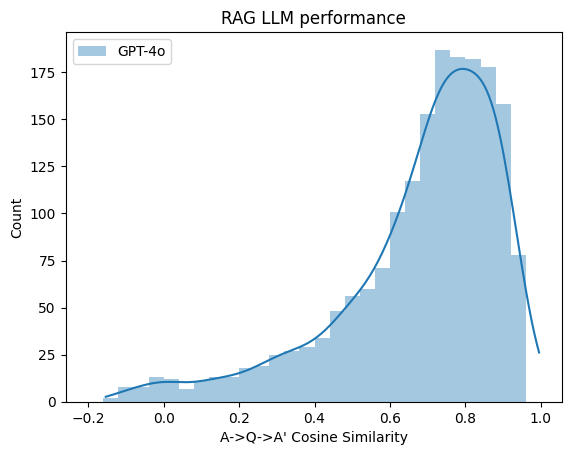

In [75]:
# Define the bin edges
bin_edges = np.arange(-0.2, 1.0, 0.04)

# Plot the histograms with KDE lines
sns.histplot(df_gpt4o['cosine'], bins=bin_edges, label='GPT-4o', kde=True, alpha=0.4, edgecolor=None)

# Set the title and labels
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()

#### gpt-3.5-turbo
* https://youtu.be/LlXclbD3pms?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=568

In [51]:
df_gpt35 = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt35.csv')

In [52]:
results_gpt35 = df_gpt35.to_dict(orient='records')
results_gpt35[0]

{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [53]:
similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:13<00:00, 13.67it/s]


In [55]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

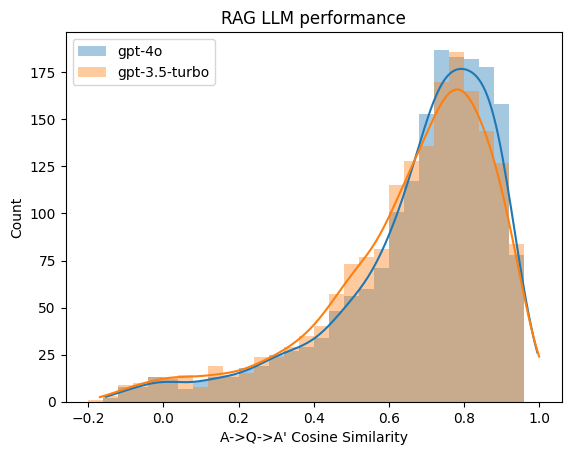

In [79]:
# Define the bin edges
bin_edges = np.arange(-0.2, 1.0, 0.04)

# Plot the histograms with KDE lines
sns.histplot(df_gpt4o['cosine'], bins=bin_edges, label='gpt-4o', kde=True, alpha=0.4, edgecolor=None)
sns.histplot(df_gpt35['cosine'], bins=bin_edges, label='gpt-3.5-turbo', kde=True, alpha=0.4, edgecolor=None)

# Set the title and labels
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()

#### gpt-4o-mini
* https://youtu.be/LlXclbD3pms?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=820

In [56]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record_4o_mini(ground_truth[10])

In [ ]:
# Costs for preparing results_gpt4omini using gpt-4o-mini are ~0.28 USD
results_gpt4omini = []

for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [57]:
df_gpt4o_mini =  pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv')

In [58]:
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')
results_gpt4omini[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [59]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:30<00:00, 12.18it/s]


In [81]:
# https://youtu.be/LlXclbD3pms?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=1304
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

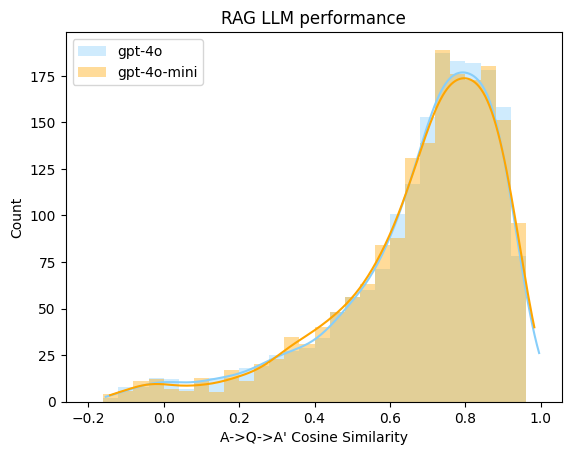

In [88]:
# Define the bin edges
bin_edges = np.arange(-0.2, 1.0, 0.04)

# Plot the histograms with KDE lines
sns.histplot(df_gpt4o['cosine'], bins=bin_edges, label='gpt-4o', kde=True, color='lightskyblue', alpha=0.4, edgecolor=None)
sns.histplot(df_gpt4o_mini['cosine'], bins=bin_edges, label='gpt-4o-mini', kde=True, color='orange', alpha=0.4, edgecolor=None)

# Set the title and labels
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()

## Offline RAG evaluation: LLM as a judge
* https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#45-offline-rag-evaluation-llm-as-a-judge
* https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/offline-rag-evaluation.ipynb

In [89]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [91]:
df_gpt4o_mini.sample(n=5)

,answer_llm,answer_orig,document,question,course,cosine
1757,You can find help for uploading datasets on Ka...,Install Nvidia drivers: https://www.nvidia.com...,f2cd48b6,Where can I find help for uploading datasets o...,machine-learning-zoomcamp,0.346446
765,The command that allows you to move to a speci...,Cd .. (go back)\nLs (see current folders)\nCd ...,620fb76e,Which command allows me to move to a specific ...,machine-learning-zoomcamp,0.582444
463,To customize the seaborn heatmap and avoid red...,data_corr = pd.DataFrame(data_num.corr().round...,1f76dbeb,How can I customize the seaborn heatmap to avo...,machine-learning-zoomcamp,0.617612
259,Checking the distribution or skewness of the t...,We can use histogram:\nimport pandas as pd\nim...,bbc0fca3,Why is checking the distribution or skewness i...,machine-learning-zoomcamp,0.322348
270,You got NaNs after applying .mean() when using...,I was using for loops to apply rmse to list of...,88e9600a,Why did I get NaNs after applying .mean() when...,machine-learning-zoomcamp,0.842591


In [92]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [93]:
samples = df_sample.to_dict(orient='records')

In [94]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [101]:
# https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=500
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [96]:
answer = llm(prompt, model='gpt-4o-mini')

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
# https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=563
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

In [ ]:
# https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=635
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [ ]:
# https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=1040
df_evaluations = pd.DataFrame(json_evaluations)

In [98]:
df_evaluations = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/evaluations-aqa.csv')
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [104]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'].head()#.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer does not address the spec...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer provides information abou...
87,NON_RELEVANT,The generated answer does not address the orig...


In [103]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

### Prompt2
* https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=1146

In [105]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
```

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [ ]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

In [ ]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

In [ ]:
# https://youtu.be/IB6jePK1s58?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R&t=1242
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [106]:
df_evaluations_2 = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/evaluations-qa.csv')
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           129
PARTLY_RELEVANT     18
NON_RELEVANT         3
Name: count, dtype: int64

In [107]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer does not address the ques...
49,NON_RELEVANT,The generated answer explicitly states that th...
139,NON_RELEVANT,The generated answer provides information abou...


In [108]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5113019943237305}

## Capturing user feedback
* https://youtu.be/XapKKBUMQ4M?list=PL3MmuxUbc_hIB4fSqLy_0AfTjVLpgjV3R
* https://github.com/DataTalksClub/llm-zoomcamp/tree/main/04-monitoring#46-capturing-user-feedback